In [2]:
# Required basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import os
import string
import joblib
from pathlib import Path

# Imports for tokenizing and vectorizing data
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Imports for vectorized data pre-processing and classification models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import unicodedata

In [3]:
def clear_tokens(tokens_list: list) -> None:
    """ Removes punctuation symbols from the given tokens list """
    # Traverse the list backwards to avoid logic problems with pop() and indexes order
    for i in range(len(tokens_list) - 1, -1, -1):
        if tokens_list[i] in string.punctuation:
            tokens_list.pop(i)
    return

def remove_emojis(keyword):
    return re.sub(r"[^\w\s,!?@#áéíóúÁÉÍÓÚñÑ]", "", keyword)

In [4]:
def tokenize_and_vectorize(data_path: str, 
                           verbose: bool=False,
                           trained_vectorizer=False,
                           accumulate_n_messages=1000) -> tuple:
    """ Tokenizes the messages from all the users and computes vectors from them """
    path            = Path(data_path)
    all_users_data  = []
    tokenizer       = TweetTokenizer()
    vectorizer      = TfidfVectorizer()
    users_order     = [] # List that stores the users in the order that are processed, for merging with the target

    # Iterate through the JSON data folder
    for element in path.iterdir():
        if element.is_file():
            user_id = re.findall(pattern=r"[0-9]+", string=element.name)[0]
            users_order.append(user_id)

            # Some execution verbose
            if verbose:
                print(f"Tokenizing messages from user: {user_id}")

            # Open and read the current JSON file
            with open(data_path + f'/{element.name}') as json_file:
                json_data = json.load(fp=json_file)

                messages = [remove_emojis(str(record['message'])) for i, record in enumerate(json_data) if i < accumulate_n_messages]
                assert len(messages) < accumulate_n_messages+1, f"more messages {len(messages)} per user than expected from accumulate_n_messages={accumulate_n_messages}"
                # Apply the TweetTokenizer algorithm
                tokenized = [tokenizer.tokenize(m) for m in messages]

                # Remove punctuation symbols tokens
                for i, t in enumerate(tokenized):
                    clear_tokens(tokens_list=t)

                    # If the resulting list is empty, then remove it
                    if len(t) == 0:
                        tokenized.pop(i)
                
                # Join the tokens of a single message, since that is what expects the implementation of TF-IDF
                user_document = " ".join(tokenized[0])
                for i in range(1, len(tokenized)):
                    tokens_joined = " ".join(tokenized[i])
                    user_document += " " + tokens_joined
                # Merge the previous data with the current user's
                all_users_data.append(user_document)

    # Vectorize all the messages with the TF-IDF and return the data as a Pandas DataFrame
    X = trained_vectorizer.transform(all_users_data)
    df = pd.DataFrame(X.toarray(), columns=trained_vectorizer.get_feature_names_out())
    
    return df, users_order, vectorizer

In [5]:
data_path_task1                        = os.getcwd() + '/data/task1/complete/subjects/'
data_path_task2                        = os.getcwd() + '/data/task2/complete/subjects/'

target_path_task1 = os.getcwd() + '/data/task1/complete/gold_task1.txt'
target_path_task2 = os.getcwd() + '/data/task2/complete/gold_task2.txt'

target_col_task1  = pd.read_csv(filepath_or_buffer=target_path_task1, delimiter=',').to_numpy()
users_tags_task1  = { re.findall(r"[0-9]+", target_col_task1[i][0])[0]: target_col_task1[i][1] for i in range(len(target_col_task1)) }

target_col_task2 = pd.read_csv(filepath_or_buffer=target_path_task2, delimiter=',').to_numpy()
users_tags_task2  = { re.findall(r"[0-9]+", target_col_task2[i][0])[0]: target_col_task2[i][1] for i in range(len(target_col_task2)) }

vectorizer_tfidf_task2 = joblib.load("trained_models/tfidf_vectorizer_task2_emojis.joblib")
model_rf_task2 = joblib.load("trained_models/RF_task2_emojis.joblib")
model_svm_task1 = joblib.load("trained_models/SVM_task1_emojis.joblib")

In [9]:
accumulate_n_messages_values = range(10, 70, 1)
accuracies_rf = []
# accuracies_svm = []

for accumulate_n_messages in accumulate_n_messages_values:
    df_vectorized_task2, users_order_task2, _ = tokenize_and_vectorize(
        data_path=data_path_task2, verbose=False, accumulate_n_messages=accumulate_n_messages, trained_vectorizer=vectorizer_tfidf_task2
    )


    # target_task1 = np.array([ users_tags_task1[user_id] for user_id in users_order_task2 ], np.int8)
    target_task2 = np.array([ users_tags_task2[user_id] for user_id in users_order_task2 ])

    df_supervised_task2 = df_vectorized_task2.copy()
    # df_supervised_task1 = df_vectorized_task2.copy()
    
    # df_supervised_task1.insert(loc=len(df_supervised_task1.columns), column='Target', value=target_task1)
    df_supervised_task2.insert(loc=len(df_supervised_task2.columns), column='Target', value=target_task2)


    X_task2, y_task2 = df_supervised_task2.drop(columns=['Target'], axis=1), df_supervised_task2['Target'].to_numpy()

    y_pred_task2 = model_rf_task2.predict(X_task2)
    acc_task2    = accuracy_score(y_true=y_task2, y_pred=y_pred_task2)
    accuracies_rf.append(acc_task2)

    # X_task1, y_task1 = df_supervised_task1.drop(columns=['Target'], axis=1), df_supervised_task1['Target'].to_numpy()

    # y_pred_task1 = model_svm_task1.predict(X_task1)
    # acc_task1  = accuracy_score(y_true=y_task1, y_pred=y_pred_task1)
    # accuracies_svm.append(acc_task1)

    print(f"accumulate_n_messages={accumulate_n_messages}, RF accuracy: {round(acc_task2, 4)}")
    # print(f"accumulate_n_messages={accumulate_n_messages}, SVM accuracy: {round(acc_task1, 2)}")



accumulate_n_messages=10, RF accuracy: 0.4902
accumulate_n_messages=11, RF accuracy: 0.5266
accumulate_n_messages=12, RF accuracy: 0.549
accumulate_n_messages=13, RF accuracy: 0.5714
accumulate_n_messages=14, RF accuracy: 0.5882
accumulate_n_messages=15, RF accuracy: 0.6246
accumulate_n_messages=16, RF accuracy: 0.6359
accumulate_n_messages=17, RF accuracy: 0.6751
accumulate_n_messages=18, RF accuracy: 0.7003
accumulate_n_messages=19, RF accuracy: 0.7311
accumulate_n_messages=20, RF accuracy: 0.7339
accumulate_n_messages=21, RF accuracy: 0.7339
accumulate_n_messages=22, RF accuracy: 0.7535
accumulate_n_messages=23, RF accuracy: 0.7675
accumulate_n_messages=24, RF accuracy: 0.7843
accumulate_n_messages=25, RF accuracy: 0.8039
accumulate_n_messages=26, RF accuracy: 0.8207
accumulate_n_messages=27, RF accuracy: 0.8347
accumulate_n_messages=28, RF accuracy: 0.8459
accumulate_n_messages=29, RF accuracy: 0.8543
accumulate_n_messages=30, RF accuracy: 0.8683
accumulate_n_messages=31, RF accura

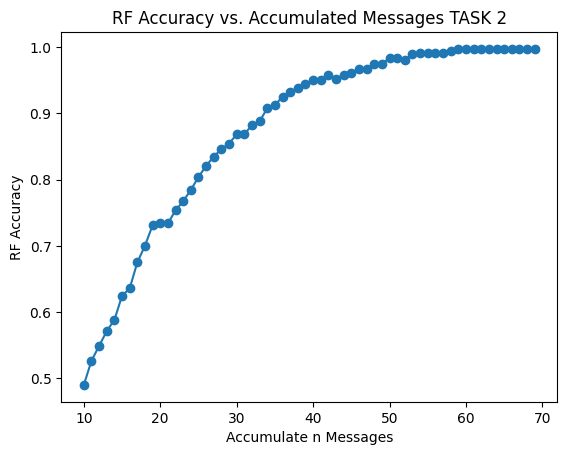

In [8]:
# Plotting the results
plt.plot(accumulate_n_messages_values, accuracies_rf, marker='o')
plt.xlabel("Accumulate n Messages")
plt.ylabel("RF Accuracy")
plt.title("RF Accuracy vs. Accumulated Messages TASK 2")
plt.show()